#  Getting the data

In [1]:
import pandas as pd

bbc_text_df = pd.read_csv('../data/bbc-text.csv')
bbc_text_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


#  Data Exploration & Visualisation

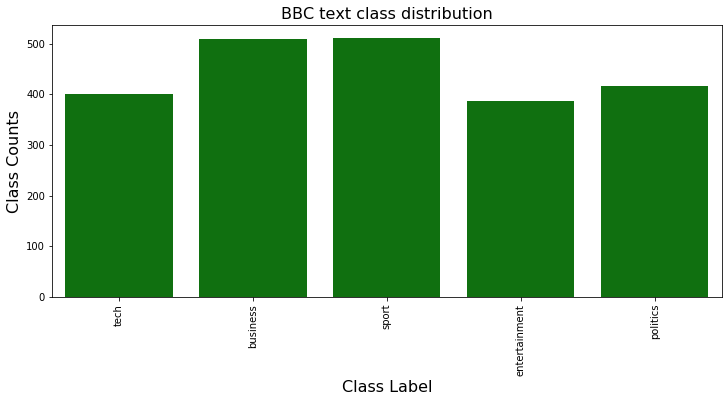

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=bbc_text_df.category, color='green')
plt.title('BBC text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [3]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [4]:
bbc_text_df.iloc[2,1]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

In [5]:
clean_text(bbc_text_df.iloc[2,1])

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

In [6]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

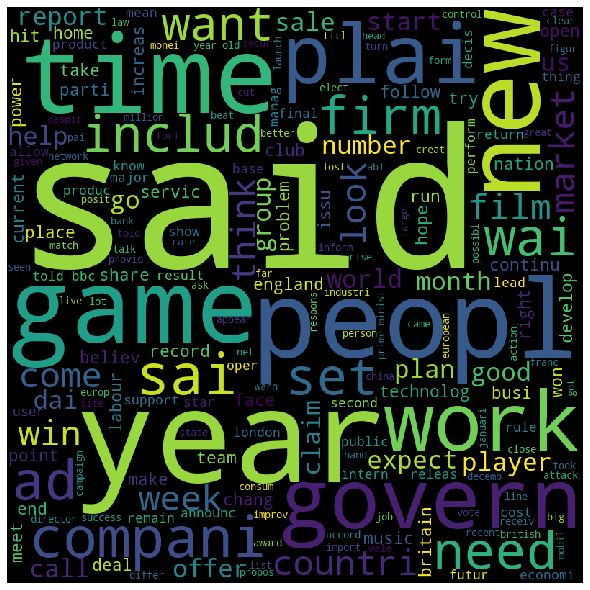

In [7]:
texts = ''
for index, item in bbc_text_df.iterrows():
    texts = texts + ' ' + clean_text(item['text'])
    
plot_word_cloud(texts)

In [8]:
def plot_word_cloud_for_category(bbc_text_df, category):
    text_df = bbc_text_df.loc[bbc_text_df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

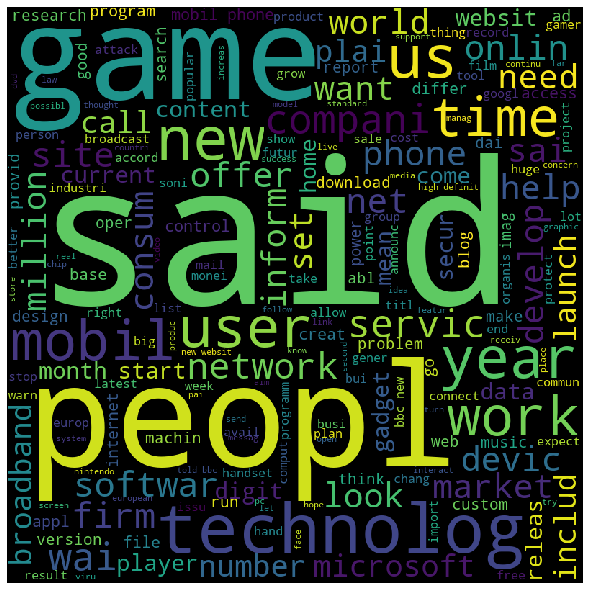

In [9]:
plot_word_cloud_for_category(bbc_text_df,'tech')

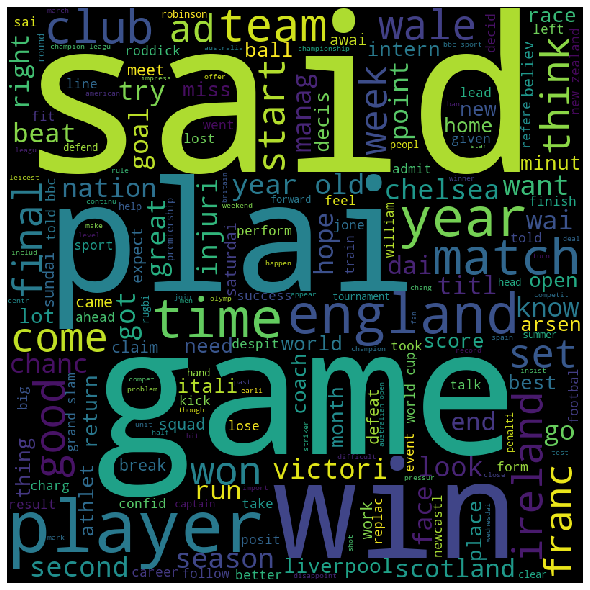

In [10]:
plot_word_cloud_for_category(bbc_text_df,'sport')

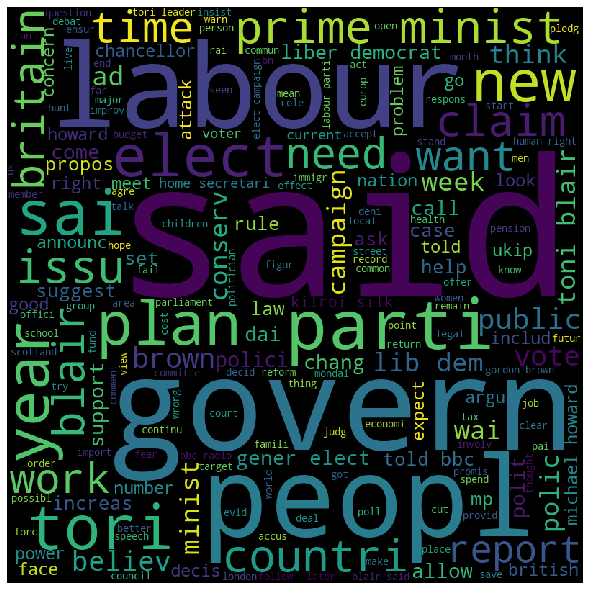

In [11]:
plot_word_cloud_for_category(bbc_text_df,'politics')

In [12]:
df_x = bbc_text_df['text']
df_y = bbc_text_df['category']

# Building the Machine Learning model & pipeline

## Converting to Doc2Vec

In [13]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [15]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 2225/2225 [00:00<00:00, 2294082.20it/s]


matrix([[-0.03542253,  0.04080631, -0.17918774, ..., -0.11864801,
          0.05611252,  0.17196238],
        [-0.02207218,  0.07430139, -0.17224479, ..., -0.20679912,
         -0.00312035,  0.12859401],
        [-0.01536881,  0.03863722, -0.18455748, ..., -0.14009747,
          0.03573041,  0.12785727],
        ...,
        [ 0.001163  ,  0.03600072, -0.11802268, ..., -0.11190537,
          0.0099861 ,  0.10438409],
        [-0.07828738,  0.00388751, -0.4044883 , ..., -0.35962152,
          0.04569223,  0.17583808],
        [-0.00487405,  0.00056318,  0.00167181, ...,  0.0014413 ,
         -0.00339641, -0.00523294]], dtype=float32)

## Pipeline with Doc2Vec & LogisticRegression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 1781/1781 [00:00<00:00, 2328570.89it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1781/1781 [00:00<00:00, 2030458.12it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1781/1781 [00:00<00:00, 2061273.57it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Logistic Regression:  0.36631972763292986


## Pipeline with Doc2Vec & RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 1777/1777 [00:00<00:00, 1820536.93it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 1780/1780 [00:00<00:00, 1673209.57it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 1781/1781 [00:00<00:00, 1698125.81it/s]
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 1781/1781 [00:00<00:00, 2108398.37it/s]
/Users/avnag/Library/Python/3.6/lib/p

Accuracy for RandomForest :  0.3411609040822524


## Pipeline with Doc2Vec & XGBoost

In [18]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 1781/1781 [00:00<00:00, 1411308.41it/s]


Accuracy for XGBoost Classifier :  0.38787987325206424


## Converting to Tf-Idf

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [20]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [21]:
tfidf_vectors.shape

(2225, 18754)

In [22]:
print(tfidf_vectors)

  (0, 18656)	0.026751783070208267
  (0, 18461)	0.012282569403139645
  (0, 18330)	0.06321612895581909
  (0, 18304)	0.1583605258104538
  (0, 18174)	0.03191861694040893
  (0, 18106)	0.07347900571034054
  (0, 18077)	0.0820082845034905
  (0, 18027)	0.08634135472606572
  (0, 17846)	0.024976845920106364
  (0, 17835)	0.03920692490243918
  (0, 17819)	0.0237112847547106
  (0, 17635)	0.10369692742506256
  (0, 17586)	0.058415007300576784
  (0, 17171)	0.42378247529420265
  (0, 17022)	0.04909762905009908
  (0, 16860)	0.024467110895914575
  (0, 16826)	0.012395674298416093
  (0, 16801)	0.04354600077310887
  (0, 16800)	0.1061221922410514
  (0, 16759)	0.019836834312179287
  (0, 16756)	0.02454881452504954
  (0, 16637)	0.108042004704681
  (0, 16625)	0.3048220054117621
  (0, 16528)	0.02112249983533661
  (0, 16356)	0.030876741901122738
  :	:
  (2224, 8118)	0.5554941760150036
  (2224, 8007)	0.10226374007302491
  (2224, 7455)	0.11194511747688254
  (2224, 7426)	0.0589324755687766
  (2224, 7372)	0.0462288710188

## Pipeline with Tf-Idf & LogisticRegression

In [23]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.8966269268867583


/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Pipeline with Tf-Idf & RandomForest

In [24]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/avnag/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/avnag/Library

Accuracy for Tf-Idf & RandomForest :  0.8548326807947595


## Pipeline with Tf-Idf & XGBoost

In [25]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.933037928578659
